In [170]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from pathlib import Path

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

In [171]:
adata_rbpj = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/objects/Rbpj_v1.h5ad"
stream_obj = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_ntc.pkl"
out_dir = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs"

In [172]:
adata = sc.read_h5ad(adata_rbpj)
adata = adata[adata.obs.condition == "NTC"]
adata

View of AnnData object with n_obs × n_vars = 5175 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'cell_cluster_colors', 'condition_colors', 'orig.ident_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [173]:
# find a gene in var names (is it in adata.var_names)
display(adata.var_names.str.contains("Ikzf2").any())
# find a gene in var names (is it in adata.var_names)
display(adata.var_names.str.contains("Ets1").any())
# find a gene in var names (is it in adata.var_names)
display(adata.var_names.str.contains("Rbpj").any())


True

False

True

In [174]:
#find if adata has var names starting with 'mt-' and print the names of such genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
adata.var["hb"] = adata.var_names.str.contains("^Hb[^(p)]")
adata.var["linc"] = adata.var_names.str.contains("Linc")

/tmp/ipykernel_15748/2865990066.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("mt-")


In [175]:
colormap = {'Tpex': 'darkblue', 'Tex': 'lightpink'}

In [176]:
categories = adata.obs['cell_cluster'].cat.categories
display(categories)
display(adata.obs['cell_cluster'].value_counts())

Index(['Tex', 'Tpex'], dtype='object')

cell_cluster
Tpex    4156
Tex     1019
Name: count, dtype: int64

In [177]:
# First, make sure the colors are in the same order as the categories
colors = [colormap[cat] for cat in categories]
# Set the colors in adata.uns
adata.uns['cell_cluster_colors'] = colors

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


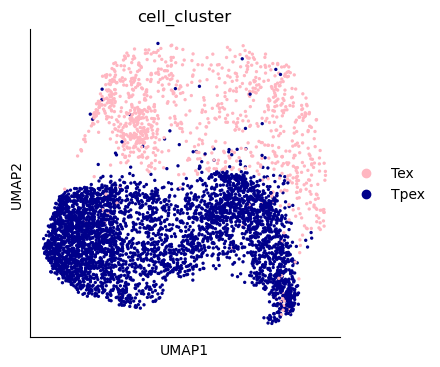

In [178]:
sc.pl.umap(adata, color=['cell_cluster'])

### Filter dataset before normalisation

In [179]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

In [180]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[:, (~adata.var['mt'] & ~adata.var['ribo'] & ~adata.var['hb'] & ~adata.var['linc'])] # Filter mitochondrial, linc, ribosomal, haemoglobin genes

In [181]:
adata

View of AnnData object with n_obs × n_vars = 4949 × 1819
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'linc', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
 

In [182]:
# normalize data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


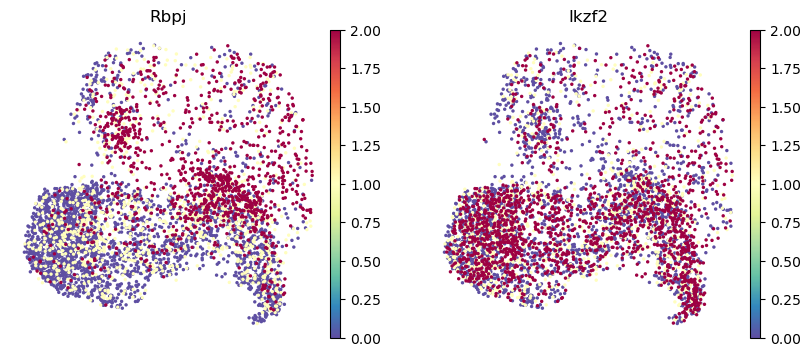

In [184]:
# pre imputation expression of 6 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    color=["Rbpj","Ikzf2"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()

### Cleanup the X matrix 

In [185]:
import scipy.sparse as sp
X = adata.X

In [186]:
if sp.issparse(X):
    data = X.data
    data[np.isnan(data)] = 0
    X.eliminate_zeros()
else:
    np.nan_to_num(X, copy=False)  # in-place: NaN->0, inf->large finite

In [187]:
n_nans = np.isnan(X.data).sum() if sp.issparse(X) else np.isnan(X).sum()
display(n_nans)
display(adata.X.size)

0

9002231

In [188]:
display(adata.X)

array([[ 3.829967  ,  2.9951491 ,  0.        , ..., -0.7453875 ,
        -0.67198783, -0.51605725],
       [ 3.4558709 ,  3.7563488 ,  0.92159504, ...,  0.58471215,
         0.5537863 ,  0.47594193],
       [ 3.2141972 ,  2.867388  , -0.8303437 , ..., -0.3511908 ,
        -0.32266062, -0.25774795],
       ...,
       [ 3.145638  ,  0.        ,  0.74027413, ...,  0.45467645,
         0.42922565,  0.36579207],
       [ 2.7094483 ,  3.0004985 ,  0.5255892 , ...,  0.3096964 ,
         0.29120752,  0.24569243],
       [ 0.        ,  0.        ,  0.        , ..., -2.0385172 ,
        -1.6604806 , -1.100525  ]], dtype=float32)

## pre-processing for diffusion

In [189]:
adata

AnnData object with n_obs × n_vars = 4949 × 1819
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'linc', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 

In [190]:
def dim_reduction(adata):
    #Scale before running PCA
    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
    return adata

In [191]:
print(adata.X.shape)
print(adata.X.max())
print(adata.X.min())

(4949, 1819)
16.369213
-13.169796


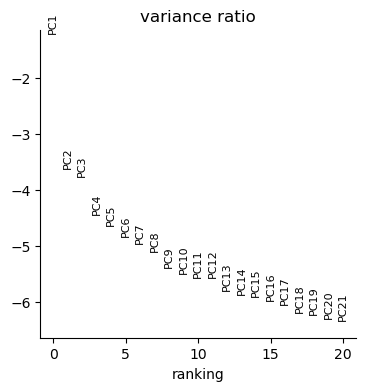

In [192]:
adata = dim_reduction(adata)

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


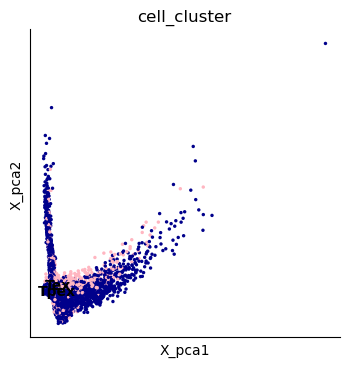

In [193]:
# plot using X_pca
sc.pl.embedding(adata, basis='X_pca', color=['cell_cluster'], legend_loc='on data')

### Run diffusion maps

In [194]:
import palantir
palantir.utils.run_diffusion_maps(adata,n_components=10) #n_components, select from the plot above, knn = 30 by default for graph construction
adata


AnnData object with n_obs × n_vars = 4949 × 1819
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'genotype', 'RNA_snn_res.0.5', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.1.2', 'RNA_snn_res.1.8', 'RNA_snn_res.2', 'celltype5', 'cell_cluster', 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'mt', 'ribo', 'hb', 'linc', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mean', 

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


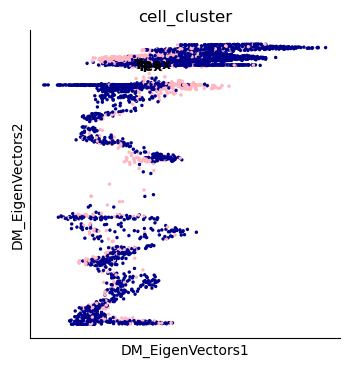

In [195]:
sc.pl.embedding(adata, basis='DM_EigenVectors', color=['cell_cluster'], legend_loc='on data')

In [196]:
palantir.utils.run_magic_imputation(adata)


array([[0.08568716, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11237012, 0.15866026, 0.42909557, ..., 0.39332896, 0.39584416,
        0.3730158 ],
       [0.2515755 , 0.09616788, 0.        , ..., 0.32373762, 0.3263247 ,
        0.28857848],
       ...,
       [0.05564086, 0.0893471 , 0.13260986, ..., 0.15531974, 0.158975  ,
        0.14856175],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.12435031, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

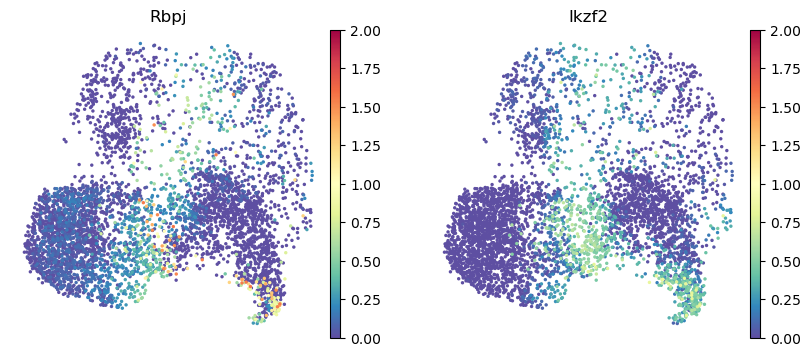

In [197]:
# post imputation expression of 6 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["Rbpj","Ikzf2"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()

In [198]:
# save the imputed adata
adata.write_h5ad("/ocean/projects/cis240075p/asachan/datasets/B_Cell/T_cell/outs/stream_objs/rbpj_rna_imputed_v1.h5ad")
